In [8]:
!pip install emoji

In [7]:
import re, html, emoji, json
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import spacy
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
# --- Parameters ---
TOP_WORDS = 10000
MAX_LEN = 200
EMBED_DIM = 300 #v3 ->100 ->300
BATCH_SIZE = 256 # v3-> 128-256
EPOCHS = 20
PLOT_DIR = "./plots"
LOG_FILE = "training_log.csv"
RESULT_JSON = "results_summary.json"

In [6]:
# Change this path to where you placed glove.6B.100d.txt
glove_path = "/Users/abhi/Desktop/DL_FINALPROJECT/glove.6B.300d.txt" # v3-> 100d to 300d

embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


In [8]:
# --- 1. Text cleaning function ---
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def clean_text(text):
    # txt = BeautifulSoup(text, "lxml").get_text(" ")
    txt = html.unescape(text)
    txt = emoji.demojize(txt, delimiters=(" ", " "))
    txt = re.sub(r"http\S+|www\S+", " ", txt)
    txt = re.sub(r"[^a-zA-Z!?'\s]", " ", txt.lower())
    doc = nlp(txt)
    tokens = [
        tok.lemma_ for tok in doc
        if tok.text not in nlp.Defaults.stop_words and tok.text.strip()
    ]
    return " ".join(tokens)

# --- 2. Load IMDB and preprocess ---
(ds_train, ds_test), _ = tfds.load(
    "imdb_reviews", split=["train", "test"], as_supervised=True, with_info=True
)

print("dataset loaded.")


dataset loaded.


In [9]:
print("cleaning data...")
train_texts, train_labels = [], []
for text, label in tfds.as_numpy(ds_train):
    train_texts.append(clean_text(text.decode("utf-8")))
    train_labels.append(label)

test_texts, test_labels = [], []
for text, label in tfds.as_numpy(ds_test):
    test_texts.append(clean_text(text.decode("utf-8")))
    test_labels.append(label)
print("data cleaned.")

cleaning data...


2025-04-30 20:41:05.507095: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-30 20:53:12.850475: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


data cleaned.


2025-04-30 21:04:44.775311: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:

# --- 3. Tokenize & pad ---
tokenizer = Tokenizer(num_words=TOP_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=MAX_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=MAX_LEN)
y_train = tf.convert_to_tensor(train_labels)
y_test = tf.convert_to_tensor(test_labels)
print("tokenization and paddding done.")

tokenization and paddding done.


In [13]:
# Build embedding matrix
embedding_matrix = np.zeros((TOP_WORDS, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i < TOP_WORDS:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec


In [14]:

# --- 4. Build Bi-LSTM model with GloVe ---
model = Sequential([
    Embedding(TOP_WORDS, EMBED_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=True),
    SpatialDropout1D(0.4),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)), 
    LayerNormalization(),  
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.2)),  
    LayerNormalization(), 
    Dropout(0.5),  
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


# --- 5. Callbacks: EarlyStopping + CSVLogger ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
csv_logger = CSVLogger(LOG_FILE)

# --- 6. Train model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, csv_logger],
    verbose=1
)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 3,000,000 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.5536 - loss: 0.8800 - val_accuracy: 0.7902 - val_loss: 0.4607
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - accuracy: 0.7465 - loss: 0.5313 - val_accuracy: 0.8394 - val_loss: 0.3758
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - accuracy: 0.8105 - loss: 0.4312 - val_accuracy: 0.8533 - val_loss: 0.3414
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.8469 - loss: 0.3624 - val_accuracy: 0.8701 - val_loss: 0.3114
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.8671 - loss: 0.3252 - val_accuracy: 0.8764 - val_loss: 0.3051
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 0.8812 - loss: 0.2961 - val_accuracy: 0.8740 - val_loss: 0.3088
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 487s 5s/step - accuracy: 0.8961 - loss: 0.2648 - val_accuracy: 0.8760 - val_loss: 0.2987
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.9034 - loss: 0.2474 - val_accuracy: 0.8788 - v

782/782 ━━━━━━━━━━━━━━━━━━━━ 128s 164ms/step - accuracy: 0.8780 - loss: 0.3018

Test Accuracy: 0.8787599802017212

Test Loss: 0.29606398940086365

Train Accuracy:  0.9369199872016907


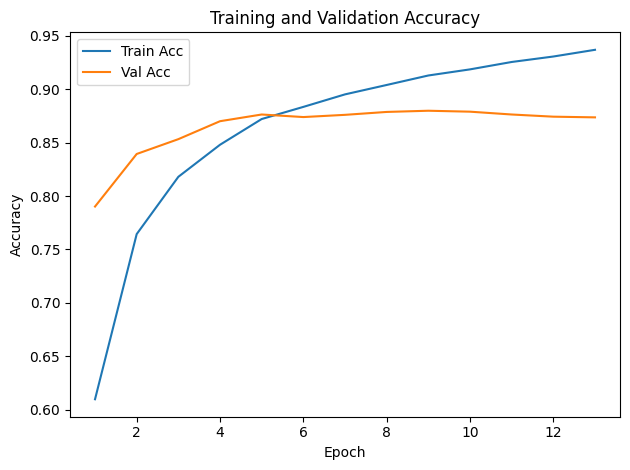

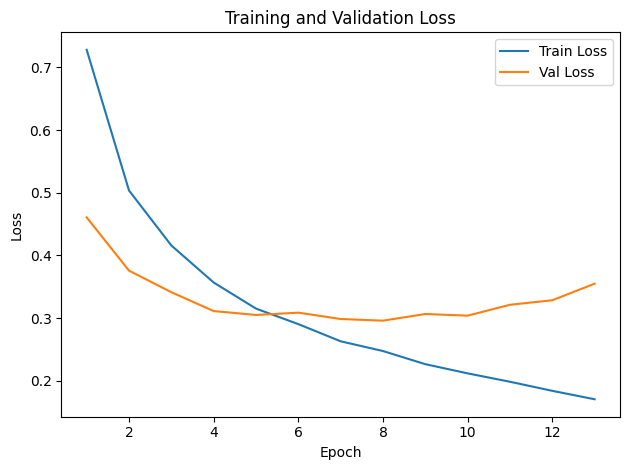

In [15]:

# --- 7. Evaluate & save results ---
loss, acc = model.evaluate(X_test, y_test, verbose=1)
summary_data = {
    "test_loss": round(float(loss), 4),
    "test_accuracy": round(float(acc), 4),
    "epochs_ran": len(history.history['accuracy']),
    "embedding_dim": EMBED_DIM,
    "max_sequence_len": MAX_LEN,
    "top_words": TOP_WORDS,
    "batch_size": BATCH_SIZE
}
with open(RESULT_JSON, "w") as f:
    json.dump(summary_data, f, indent=2)

print("\nTest Accuracy:", acc)
print("\nTest Loss:", loss)

print("\nTrain Accuracy: ", history.history['accuracy'][-1])

# --- 8. Plot training history ---
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure()
plt.plot(epochs_range, history.history['accuracy'], label='Train Acc')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
import os
os.makedirs(PLOT_DIR, exist_ok=True)
plt.savefig(f"{PLOT_DIR}/accuracy_plot.png")

plt.figure()
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/loss_plot.png")